<a href="https://colab.research.google.com/github/nlemoff/data102project/blob/main/Checkpoint2_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd

emissions_df = pd.read_csv('state_emissions.csv')
energy_df = pd.read_csv('state_wise_energy_all_sectors.csv')
temperature_df = pd.read_csv('temperature_data_2023.csv')

In [54]:
ca_2023_emissions_clean = ca_2023_emissions[
    (ca_2023_emissions['stateid'] == 'CA') &
    (ca_2023_emissions['fuelid'] == 'ALL')
][['period', 'co2-thousand-metric-tons']]

print("Cleaned emissions data:")
print(ca_2023_emissions_clean)
print("\nData types:")
print(ca_2023_emissions_clean.dtypes)

Cleaned emissions data:
     period  co2-thousand-metric-tons
240    2023                     43360

Data types:
period                      int64
co2-thousand-metric-tons    int64
dtype: object


In [55]:
ca_2023_emissions_clean

,period,co2-thousand-metric-tons
240,2023,43360


In [56]:
# Convert to Celsius and handle missing months
monthly_temp['value'] = (monthly_temp['value'] - 32) * 5/9  # Convert F to C

# Create a complete month range
all_months = pd.date_range(start='2023-01-01', end='2023-12-31', freq='M')
all_months_df = pd.DataFrame({'month': all_months.strftime('%Y-%m')})

monthly_temp_complete = pd.merge(all_months_df, monthly_temp, on='month', how='left')

print("Monthly average temperatures (Celsius):")
print(monthly_temp_complete)
print("\nMissing months:")
print(monthly_temp_complete[monthly_temp_complete['value'].isna()])

Monthly average temperatures (Celsius):
      month      value
0   2023-01 -13.448414
1   2023-02 -13.916534
2   2023-03 -12.855322
3   2023-04   5.693658
4   2023-05  15.429503
5   2023-06  23.959391
6   2023-07  45.689343
7   2023-08  40.441128
8   2023-09  26.452321
9   2023-10  18.625632
10  2023-11   2.150191
11  2023-12  -3.581983

Missing months:
Empty DataFrame
Columns: [month, value]
Index: []


<ipython-input-56-bbe2e4197c56>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range(start='2023-01-01', end='2023-12-31', freq='M')


In [57]:
# Check energy data
print("Energy consumption data:")
print(energy_df[energy_df['stateid'] == 'CA'][['period', 'sales']].head(12))
print("\nData types:")
print(energy_df.dtypes)

Energy consumption data:
     period        sales
0   2024-01  20040.74935
1   2023-12  18660.12634
2   2023-11  18479.20564
3   2023-10  20390.47299
4   2023-09  22466.03859
5   2023-08  25101.55563
6   2023-07  23048.26218
7   2023-06  19333.43379
8   2023-05  18288.41200
9   2023-04  16261.33366
10  2023-03  19506.41869
11  2023-02  17440.48579

Data types:
period               object
stateid              object
stateDescription     object
sectorid             object
sectorName           object
sales               float64
sales-units          object
dtype: object


In [58]:
# only include 2023
energy_clean = energy_df[
    (energy_df['stateid'] == 'CA') &
    (energy_df['period'].str.startswith('2023'))
].copy()

energy_clean['month'] = pd.to_datetime(energy_clean['period']).dt.strftime('%Y-%m')
final_df = pd.merge(monthly_temp, energy_clean[['month', 'sales']], on='month')
final_df = final_df.rename(columns={'value': 'temperature', 'sales': 'energy_demand'})
final_df['emissions'] = ca_2023_emissions_clean['co2-thousand-metric-tons'].values[0] / 12

print("Final dataset for causal analysis:")
print(final_df)
print("\nData types:")
print(final_df.dtypes)

# Basic correlations
print("\nCorrelations:")
print(final_df[['temperature', 'energy_demand', 'emissions']].corr())

Final dataset for causal analysis:
      month  temperature  energy_demand    emissions
0   2023-01   -13.448414    20504.70675  3613.333333
1   2023-02   -13.916534    17440.48579  3613.333333
2   2023-03   -12.855322    19506.41869  3613.333333
3   2023-04     5.693658    16261.33366  3613.333333
4   2023-05    15.429503    18288.41200  3613.333333
5   2023-06    23.959391    19333.43379  3613.333333
6   2023-07    45.689343    23048.26218  3613.333333
7   2023-08    40.441128    25101.55563  3613.333333
8   2023-09    26.452321    22466.03859  3613.333333
9   2023-10    18.625632    20390.47299  3613.333333
10  2023-11     2.150191    18479.20564  3613.333333
11  2023-12    -3.581983    18660.12634  3613.333333

Data types:
month             object
temperature      float64
energy_demand    float64
emissions        float64
dtype: object

Correlations:
               temperature  energy_demand  emissions
temperature       1.000000       0.694786        NaN
energy_demand     0.694786  

First Stage Results (Temperature -> Energy Demand):
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          1.9e+04    632.266     30.052      0.000    1.76e+04    2.04e+04
temperature    85.1703     27.880      3.055      0.012      23.049     147.292


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


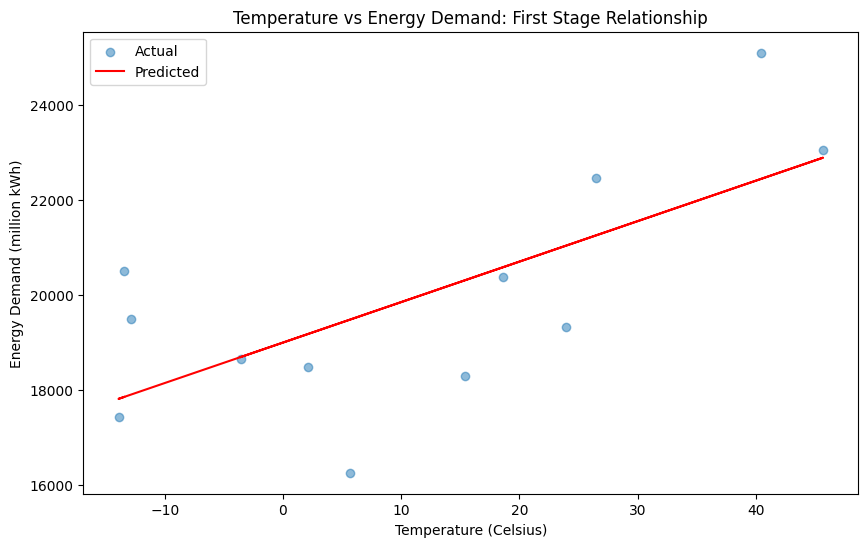

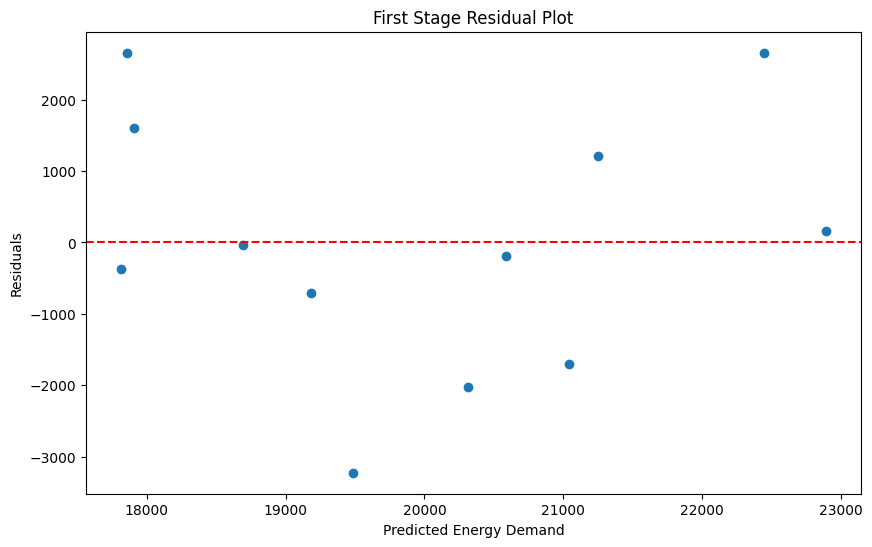

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

X_first = sm.add_constant(final_df['temperature'])
first_stage = sm.OLS(final_df['energy_demand'], X_first).fit()

energy_demand_predicted = first_stage.predict(X_first)

print("First Stage Results (Temperature -> Energy Demand):")
print(first_stage.summary().tables[1])

import matplotlib.pyplot as plt

# Plot actual vs predicted energy demand
plt.figure(figsize=(10, 6))
plt.scatter(final_df['temperature'], final_df['energy_demand'], alpha=0.5, label='Actual')
plt.plot(final_df['temperature'], energy_demand_predicted, color='red', label='Predicted')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Energy Demand (million kWh)')
plt.title('Temperature vs Energy Demand: First Stage Relationship')
plt.legend()
plt.show()

# Plot residuals
residuals = first_stage.resid
plt.figure(figsize=(10, 6))
plt.scatter(energy_demand_predicted, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Energy Demand')
plt.ylabel('Residuals')
plt.title('First Stage Residual Plot')
plt.show()

In [60]:
# Second stage regression
X_second = sm.add_constant(energy_demand_predicted)
second_stage = sm.OLS(final_df['emissions'], X_second).fit()
print(second_stage.summary())


                            OLS Regression Results                            
Dep. Variable:              emissions   R-squared:                    -149.583
Model:                            OLS   Adj. R-squared:               -164.642
Method:                 Least Squares   F-statistic:                    -9.934
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               1.00
Time:                        20:38:20   Log-Likelihood:                 293.91
No. Observations:                  12   AIC:                            -583.8
Df Residuals:                      10   BIC:                            -582.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3613.3333   2.11e-11   1.72e+14      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


let's try distributing emissions proportionally


In [61]:
# Distribute annual emissions based on energy demand
total_energy = energy_clean['sales'].sum()  # Total energy demand for 2023
final_df['emissions'] = final_df['energy_demand'] / total_energy * ca_2023_emissions_clean['co2-thousand-metric-tons'].values[0]

print("Updated emissions data:")
print(final_df[['month', 'emissions']])


Updated emissions data:
      month    emissions
0   2023-01  3712.553894
1   2023-02  3157.750277
2   2023-03  3531.805236
3   2023-04  2944.254621
4   2023-05  3311.274626
5   2023-06  3500.484829
6   2023-07  4173.086528
7   2023-08  4544.853005
8   2023-09  4067.669928
9   2023-10  3691.870887
10  2023-11  3345.819459
11  2023-12  3378.576711


In [63]:
# Add squared temperature term for non-linear effects
final_df['temperature_squared'] = final_df['temperature'] ** 2

# First-stage regression (include non-linear term)
X_first = sm.add_constant(final_df[['temperature', 'temperature_squared']])
first_stage = sm.OLS(final_df['energy_demand'], X_first).fit()

# Predict energy demand
final_df['energy_demand_predicted'] = first_stage.predict(X_first)

# Second-stage regression
X_second = sm.add_constant(final_df['energy_demand_predicted'])
second_stage = sm.OLS(final_df['emissions'], X_second).fit()

# Print results
print("Second Stage Results (Energy Demand -> Emissions):")
print(second_stage.summary())


Second Stage Results (Energy Demand -> Emissions):
                            OLS Regression Results                            
Dep. Variable:              emissions   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     21.72
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           0.000893
Time:                        20:40:23   Log-Likelihood:                -83.071
No. Observations:                  12   AIC:                             170.1
Df Residuals:                      10   BIC:                             171.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


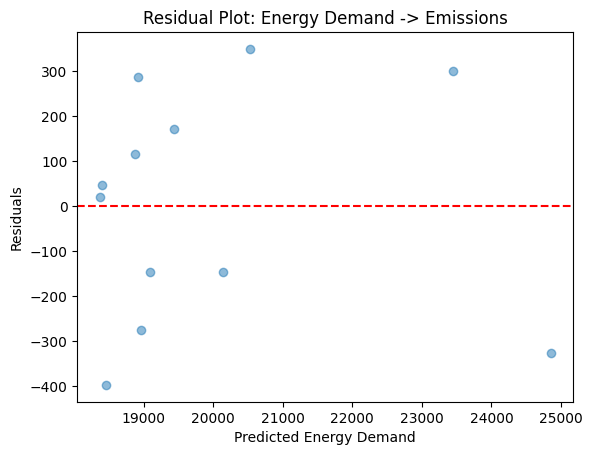

Breusch-Pagan Test Results: (1.7468854626216337, 0.18626875264110246, 1.7037607999532765, 0.2210299914852364)


In [64]:
# Residuals of second stage
residuals = second_stage.resid

# Residual plot
plt.scatter(final_df['energy_demand_predicted'], residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Energy Demand')
plt.ylabel('Residuals')
plt.title('Residual Plot: Energy Demand -> Emissions')
plt.show()

# Breusch-Pagan test
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuals, X_second)
print("Breusch-Pagan Test Results:", bp_test)
